# Tarea 2
### Integrantes:
- Pablo Araya
- Benjamin Barrientos
- Sebastian Lopez

# P1. Carga y transformación de datos
Al abordar un problema de clasificacióon de imágenes con redes neuronales profundas, es importante optimizar
el proceso de carga de datos. Al tratarse de im´agenes, es de esperar que no todas las muestras puedan ser
almacenadas en memoria de manera simultanea, por lo que es necesario construir un generador. El objetivo de la
sección es construir un generador de muestras eficiente, que minimice el tiempo de carga de datos y optimice el
uso de memoria. 

El conjunto de datos a utilizar esta disponible en este link. En la Figura 1 se observan algunas muestras
de cada clase. La carpeta train consta de alrededor de 5.000 im´agenes y la carpeta test, cerca de 600. Al ser
un conjunto de datos peque˜no, se emplean t´ecnicas de aumentaci´on de datos que ser´an detalladas a continuaci´on.

In [1]:
! wget "https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip"

--2020-07-18 02:24:02--  https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497 [following]
--2020-07-18 02:24:02--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/31ab5ede-ed34-46d4-b1bf-c63d70411497
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.109.112
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.109.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12355

In [2]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile('ChestXRay2017.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Cargamos las librerías

In [3]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)

In [4]:
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

Procedemos a hacer funciones y tranformaciones para imágenes.

In [5]:
def loader(path):
    ''' Cargar la imagen '''
    Img = Image.open(path)
    '''Verificar que tenga 3 canales '''
    if len(Img.split()) == 1:
        Img = Image.merge("RGB", (Img.split()[0], Img.split()[0], Img.split()[0]))
    return Img

''' Conjunto de Transformaciones '''
transformaciones_train = transforms.Compose([transforms.Resize([224,224]),
                                             transforms.RandomHorizontalFlip(p=0.5),
                                             transforms.RandomRotation(degrees=(-20,20)),
                                             transforms.Lambda(lambda img: img.point(lambda i: i*np.random.uniform(1.2,1.5))),
                                             transforms.ToTensor()])

transformaciones_test = transforms.Compose([transforms.Resize([224,224]),
                                            transforms.ToTensor()])

''' Se cargan los datos y se les aplica las transformaciones anteriores '''
data_train = datasets.DatasetFolder(root='chest_xray/train',loader = loader,extensions = ('jpeg'),
                                    transform=transformaciones_train)
data_test = datasets.DatasetFolder(root='chest_xray/test',loader = loader,extensions = ('jpeg'),
                                   transform=transformaciones_test)

Probamos SKImage

In [6]:
from skimage.io import imread,imread_collection, imshow
from skimage import exposure
import skimage.transform

Con sus respectivos loaders y transformaciones

In [7]:
def loader_ski(path):
    ''' Cargar la imagen.
    '''
    Img = imread(path)
    # Verificar si tiene 3 canales.
    if len(Img.shape) == 2: 
        Img = skimage.color.gray2rgb(Img)
    return Img

def h_flip(Img):
    ''' Funcion para voltear la imagen.
    '''
    azar = np.random.randint(0,2)
    if azar == 1:
        return np.fliplr(Img)
    return Img

def f_brillo(array):
    ''' Funcion para multiplicar los pixeles del brillo.
    '''
    return np.array([np.array([x*np.random.uniform(1.2,1.5) for x in y]) for y in array])

''' Transformaciones para el conjunto de entramiento '''
transformaciones_train = transforms.Compose([transforms.Lambda(lambda img: skimage.transform.resize(img,(224,224))),
                                             transforms.Lambda(lambda img: exposure.adjust_gamma(img,gamma = 1/np.max(img),gain=1)),
                                             transforms.Lambda(lambda img: h_flip(img)),
                                             transforms.Lambda(lambda img: skimage.transform.rotate(img,np.random.uniform(-20,20))),
                                             transforms.Lambda(lambda img: np.array([f_brillo(x) for x in img])),
                                             transforms.ToTensor()])

''' Transformaciones para el conjunto de testeo '''
transformaciones_test = transforms.Compose([transforms.Lambda(lambda img: skimage.transform.resize(img,(224,224))),
                                            transforms.ToTensor()])

''' Se cargan los datos y se les aplica las transformaciones anteriores '''
data_train_ski = datasets.DatasetFolder(root='chest_xray/train',loader = loader_ski,extensions = ('jpeg'),
                                    transform=transformaciones_train)
data_test_ski = datasets.DatasetFolder(root='chest_xray/test',loader = loader_ski,extensions = ('jpeg'),
                                   transform=transformaciones_test)

Visualizamos las imágenes de testeo y prueba

In [8]:
def mostrar_imagenes(m=4, tipo='train',modo = 'PIL'):
    ''' Funcion para mostrar las imagenes (al azar) luego de las transformaciones. '''
    fig, ax = plt.subplots(1, m, figsize=(15, 8))
    for i in range(m):
        if tipo == 'train':
            num = np.random.randint(5233)
            if modo == 'PIL':
                ax[i].imshow(data_train[num][0].permute(1,2,0))#[1, :])
            if modo == 'ski':
                ax[i].imshow(data_train_ski[num][0].permute(1,2,0))#[1, :])
        if tipo == 'test':
            num = np.random.randint(621)
            if modo == 'PIL':
                ax[i].imshow(data_test[num][0].permute(1,2,0))#[1, :])
            if modo == 'ski':
                ax[i].imshow(data_test_ski[num][0].permute(1,2,0))#[1, :])
    
        if data_train[num][1] == 0:
            ax[i].title.set_text('NORMAL')
        else:
            ax[i].title.set_text('PNEUMONIA')
    plt.tight_layout()
    plt.show()
    return

PIL

TRAIN


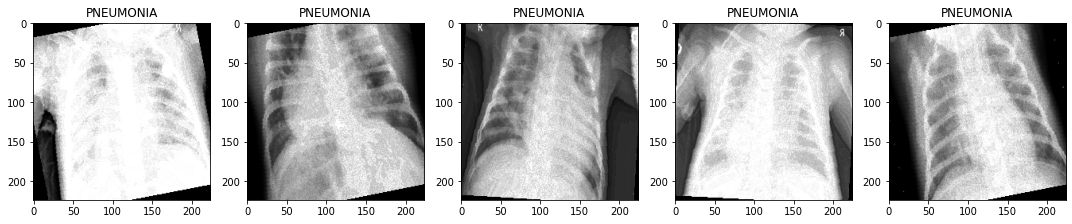

TEST


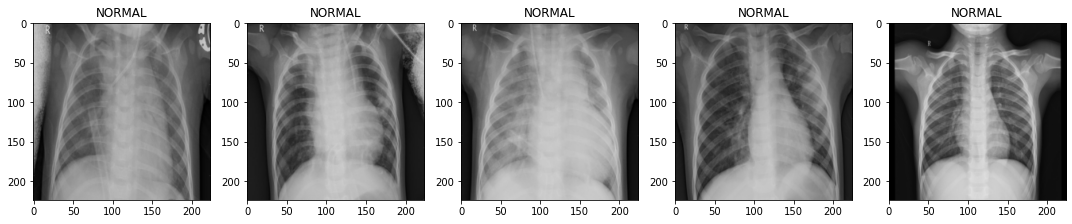

In [9]:
print('TRAIN')
mostrar_imagenes(5)
print('TEST')
mostrar_imagenes(5, 'test')

TRAIN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


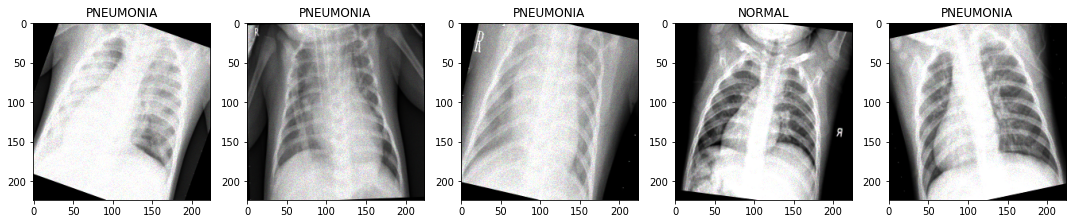

TEST


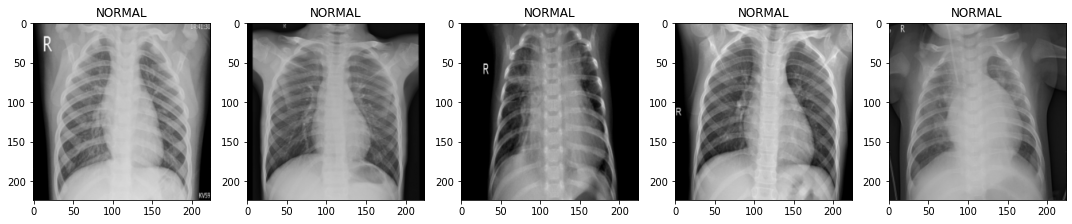

In [10]:
'''skimage'''
print('TRAIN')
mostrar_imagenes(5,modo = 'ski')
print('TEST')
mostrar_imagenes(5,tipo = 'test',modo = 'ski')

#### Verificar tiempos de ejecucion

In [11]:
''' PIL ''' 
%timeit -r 5 data_train[0][0]

10 loops, best of 5: 51.4 ms per loop


In [12]:
''' Skimage '''
%timeit -r 5 data_train_ski[0][0]

1 loop, best of 5: 1.06 s per loop


## Parte 2

In [13]:
''' Tipo de Imagenes en el conjunto Train '''
pneumonia_train = sum(data_train.targets)
normal_train = len(data_train.targets) - pneumonia_train
print('TRAIN DATA -', 'NORMAL: {},'.format(normal_train), 'PNEUMONIA: {},'.format(pneumonia_train),
      'TOTAL: {}'.format(normal_train + pneumonia_train))

''' Tipo de Imagenes en el conjunto Test '''
pneumonia_test = sum(data_test.targets)
normal_test = len(data_test.targets) - pneumonia_test
print('TEST DATA -', 'NORMAL: {}'.format(normal_test),'PNEUMONIA: {}'.format(pneumonia_test),
      'TOTAL: {}'.format(normal_test + pneumonia_test))

TRAIN DATA - NORMAL: 1349, PNEUMONIA: 3883, TOTAL: 5232
TEST DATA - NORMAL: 234 PNEUMONIA: 390 TOTAL: 624


Realizamos visualizaciones

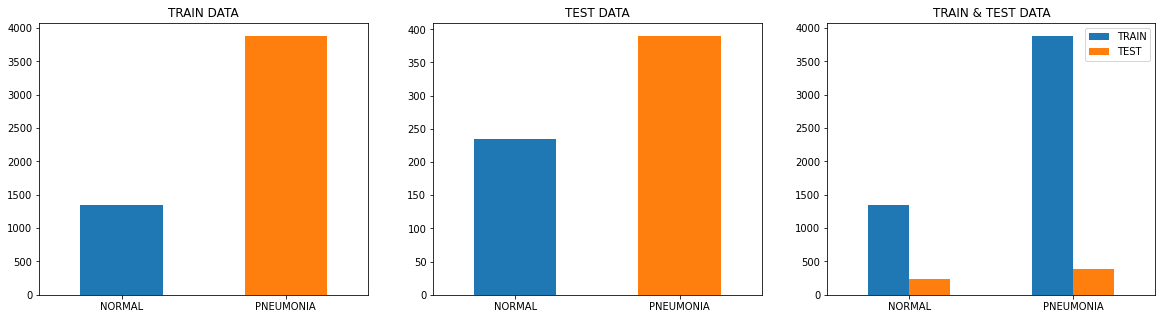

In [14]:
datos_train = {'TRAIN' : [normal_train, pneumonia_train],
               'TEST' : [normal_test, pneumonia_test]}
index = ['NORMAL', 'PNEUMONIA']

df = pd.DataFrame(datos_train, index = index)

fig, ax = plt.subplots(1,3, figsize = (20,5))

# Plot
df['TRAIN'].plot(ax = ax[0],color=['C0','C1'], kind='bar', rot=0)
df['TEST'].plot(ax = ax[1],color=['C0','C1'], kind = 'bar', rot=0)
df.plot(ax = ax[2], kind = 'bar',rot=0)

# Títulos
ax[0].title.set_text('TRAIN DATA')
ax[1].title.set_text('TEST DATA')
ax[2].title.set_text('TRAIN & TEST DATA')
plt.show()

## Parte 3

Separamos en conjunto de entrenamiento y validación de 80% y 20% del total de los datos.

In [15]:
from sklearn.model_selection import train_test_split

''' Se generan los indices de cada conjunto '''
index_X = np.arange(0,len(data_train))
index_X_train, index_X_validation = train_test_split(index_X, test_size = .2,random_state = 23)

''' Con los indices anteriores se generan las etiquetas correspondientes a cada indice '''
etiqueta_train = np.array([data_train[obs][1] for obs in index_X_train])
etiqueta_validation = np.array([data_train[obs][1] for obs in index_X_validation])
etiqueta_test = np.array([obs[1] for obs in data_test])

In [16]:
Dist_test = np.sum(etiqueta_test)/(len(etiqueta_test))
print('Distribucion Conjunto Testeo: ',Dist_test)

Distribucion Conjunto Testeo:  0.625


In [17]:
class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        ''' Parametros '''
        self.etiquetas_prueba = etiquetas_prueba
        self.indices_val = indices_val
        self.etiquetas_val = etiquetas_val
        
    def __iter__(self):
        ''' Probabilidad de ser 1 en el conjunto de prueba '''
        test_prob = np.sum(self.etiquetas_prueba)/len(self.etiquetas_prueba)
        ''' Se define el vector de probabilidades dependiendo del valor de p_test'''
        if test_prob < 0.5:
            vect_prob = self.etiquetas_val 
        else:
            vect_prob = 1 - self.etiquetas_val
        ''' Se Normaliza para que sea un vector de probabilidad '''
        vect_prob = vect_prob/np.sum(vect_prob)
        
        ''' Punto de Partida '''
        Sam = self.indices_val
        Etiqueta_Sam = self.etiquetas_val
        prob_Sam = np.sum(Etiqueta_Sam)/len(Etiqueta_Sam)
        ''' Iteraciones '''
        while abs(prob_Sam - test_prob) > 5*1e-4:
            ''' Se elige un indice al azar '''
            index = np.random.choice(np.arange(len(self.indices_val)), size=1, p=vect_prob)
            Nuevo_indice = self.indices_val[index]
            Nueva_etiqueta = self.etiquetas_val[index]
            ''' Se actualizan las muestras al agregar el nuevo indice '''
            Sam = np.append(Sam, Nuevo_indice)
            Etiqueta_Sam = np.append(Etiqueta_Sam, Nueva_etiqueta)
            prob_Sam = np.sum(Etiqueta_Sam)/len(Etiqueta_Sam)
        return iter(Sam)

In [18]:
Sam = ReplicarMuestreoDePrueba(etiqueta_test,index_X_validation,etiqueta_validation)
Sam_iter = Sam.__iter__()
Dist_Sam = [etiqueta_validation[list(index_X_validation).index(n)] for n in Sam_iter]
print('Distribucion Sampleo Validacion: ',np.sum(Dist_Sam)/len(Dist_Sam))

Distribucion Sampleo Validacion:  0.6251018744906276


## Parte 4

In [19]:
from torch.utils.data import DataLoader,RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler

train_dl = DataLoader(data_train, batch_size=5,sampler = SubsetRandomSampler(torch.from_numpy(index_X_train)))
val_dl = DataLoader(data_train, batch_size=5,sampler = Sam)
test_dl = DataLoader(data_test, batch_size=5,sampler = RandomSampler(data_test))

In [20]:
def tiempo_num_workers(n,tipo = 'train'):
    ''' Funcion para estudiar el tiempo que demora en sacar una muestra para distintos numero de workers. '''
    if tipo == 'train':
        DL = DataLoader(data_train, batch_size=16,sampler = SubsetRandomSampler(torch.from_numpy(index_X_train)),num_workers = n)
    if tipo == 'val':
        DL = DataLoader(data_train, batch_size=16,sampler = Sam,num_workers = n)
    if tipo == 'test':
        Dl = DataLoader(data_test, batch_size=16,sampler = RandomSampler(data_test),num_workers = n)
    for obs in DL:
        break

In [21]:
%timeit -r 10 tiempo_num_workers(0)

1 loop, best of 10: 243 ms per loop


In [22]:
%timeit -r 10 tiempo_num_workers(1)

1 loop, best of 10: 323 ms per loop


In [23]:
%timeit -r 10 tiempo_num_workers(2)

1 loop, best of 10: 742 ms per loop


In [24]:
%timeit -r 10 tiempo_num_workers(3)

1 loop, best of 10: 1.2 s per loop


In [25]:
%timeit -r 10 tiempo_num_workers(4)

1 loop, best of 10: 1.44 s per loop


# P2. Redes convolucionales profundas

## Arquitectura

El objetivo de esta secci´on es construir una red neuronal profunda para el problema de clasificaci´on de
im´agenes de rayos X sobre neumon´ıa. Dicha red debe ser implementada en Pytorch.
Se implementa un tipo de capa de convoluci´on conocida como Dephtwise Separable Convolution [2]. Esta
consiste en separar una capa de k filtros de convoluci´on de tama˜no n × n, i.e. definida por k filtros de tama˜no
n × n × c (donde c representa el n´umero de canales) en dos capas de convoluci´on:

In [26]:
class DWSepConv2d(nn.Module):
    ''' Clase que implementa Dephtwise Separable Convolution.'''
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   padding=padding, bias=True) #, groups=in_channels
        
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True)

    def forward(self, x):
        x = self.depthwise(x)
        out = F.relu(self.pointwise(x))
        return out

Ocupamos la clase anterior para hacer la red convolucional.

In [27]:
class VGG16DWSep(nn.Module):
    ''' Red convolucional profunda.
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)
        
        self.dwsep1 = DWSepConv2d(64,128,kernel_size = 3, padding = 1)
        self.dwsep2 = DWSepConv2d(128,128,kernel_size = 3, padding = 1)

        self.dwsep3 = DWSepConv2d(128,256,kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(256)
        self.dwsep4 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.dwsep5 = DWSepConv2d(256,256,kernel_size = 3, padding = 1)
        self.mp3 = nn.MaxPool2d(kernel_size = 2, stride=2)
        self.dwsep6 = DWSepConv2d(256,512,kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dwsep7 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        self.dwsep8 = DWSepConv2d(512,512,kernel_size = 3, padding = 1)
        
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(512*49*4,1024)
        self.do1 = nn.Dropout(p=0.7)
        self.lin2 = nn.Linear(1024,512)
        self.do2 = nn.Dropout(p=0.5)
        self.out = nn.Linear(512,2)
        
    def forward(self,x):
        x = x.view(-1,3,224,224)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep1(x))
        x = F.relu(self.dwsep2(x))
        x = self.pool(x)
        x = F.relu(self.dwsep3(x))
        x = F.relu(self.bn1(x))
        x = F.relu(self.dwsep4(x))
        x = F.relu(self.bn2(x))
        x = F.relu(self.dwsep5(x))
        x = self.pool(x)
        x = F.relu(self.dwsep6(x))
        x = F.relu(self.bn3(x))
        x = F.relu(self.dwsep7(x))
        x = F.relu(self.bn4(x))
        x = F.relu(self.dwsep8(x))
        x = self.pool(x)
        x = self.flat(x)
        x = F.relu(self.lin1(x))
        x = self.do1(x)
        x = F.relu(self.lin2(x))
        x = self.do2(x)
        x = F.relu(self.out(x))
        return x

Probamos una imagen

In [28]:
model = VGG16DWSep()
model.forward(data_train[0][0])

tensor([[0.0000, 0.0167]], grad_fn=<ReluBackward0>)

Número de parámetros

In [29]:
sum(p.numel() for p in model.parameters())

110997378

Cargamos el modelo ya entrenado VGG16

In [30]:
from torchvision import models
model_vgg16 = models.vgg16(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Congelamos las capas

In [31]:
weight_layer1, weight_layer2 = model_vgg16.features[0].weight, model_vgg16.features[2].weight
weight_layer1.requires_grad, weight_layer2.requires_grad = False, False

Fijamos las primeras capas de VVG16 a nuestro modelo

In [32]:
with torch.no_grad():
    model.conv1.weight.copy_(model_vgg16.features[0].weight)
    model.conv2.weight.copy_(model_vgg16.features[2].weight)

## EarlyStopping y entrenamiento

Se implementa la clase EarlyStopping

In [33]:
class EarlyStopping():
    ''' Clase para detener el entrenamiento.
    '''
    def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
        '''Parámetros auto-explicativos.
        '''
        self.modo = modo
        self.paciencia = paciencia
        self.porcentaje = porcentaje
        self.tol = tol
        self.observacion = None
        self.epocas = None

    def mejor(self, metrica_validacion):
        '''
        Método que retorna True si metrica_validacion es mejor que la observación.
        
        Dependiendo de los parámetros entregados al iniciar la clase, compara
        metrica_validacion con la observación.
        
        Args:
        ----------

        metrica_validacion: Float
        
        Returns: bool
            True si metrica_validacion es mejor que la observación, False si no.
        '''
        
        
        if self.observacion is None:
            self.observacion = metrica_validacion
            self.epocas = 1
            return True
        
        diferencia = metrica_validacion - self.observacion
        cuociente = metrica_validacion/self.observacion

        if modo == 'min':
            if self.porcentaje:
                # Si el cuociente empeoro en 40% = 0.4
                if cuociente < tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False
            else:
                # Si la metrica es mejor..
                if diferencia < tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False

        else:  # if modo == 'max'
            if self.porcentaje:
                if cuociente > 1+tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False
            else:
                if diferencia > tol:
                    self.epocas = 0
                    return True
                self.epocas += 1
                return False

    def deberia_parar(self, metrica_validacion):
        ''' Método que decide si algoritmo se detiene.
        
        Args:
        ----------
        metrica_validacion: Float
        
        Returns: bool
            Decide si parar dependiendo de cuantas épocas han pasado.
        '''
        # Si estoy al límite y no mejoré
        if self.epocas == self.paciencia and not mejor(self, metrica_validacion):
            return True
        return False

Función para entrenar el modelo

In [49]:
from sklearn.metrics import f1_score

def train(epochs, model, loss_func, optimizer, train_dl, valid_dl):
    ''' Funcion que entrena el modelo.
    
    Args:
    ----------

    epochs: Int
        Épocas para entrenar el modelo.
    
    model: torchvision.model
        Modelo a entrenar.
        
    loss_func: function
        Función de perdida.
        
    optimizer: torch.optim
        Algoritmo de optimización.
    
    train_dl: torch.utils.data.dataloader.DataLoader
        DataLoader de entrenamiento.
    
    valid_dl: torch.utils.data.dataloader.DataLoader
        DataLoader de validación.
        
    Returns: Accuracy (list), F1-score (list), model
        Regresa la presición, F1-score y el modelo entrenado.
        
    '''
    instancia = EarlyStopping()
    f1_scores = []
    val_accuracy = []
    train_accuracy = []
    train_loss_vect = []
    
    print('Cambiando a GPU...')
    model.cuda()
    print('... Done')

    for epoch in range(epochs):
        train_loss = 0.0
        f1 = 0.0
        
        correct = 0
        total = 0

        targets = []
        outputs = []
        print('Empezamos el entrenamiento...')
        #ciclo de entrenamiento
        for i, (data, target) in enumerate(train_dl):
            # Pasamos a GPU
            data, target = data.cuda(), target.long().cuda()
            
            # Limpiamos los gradientes
            optimizer.zero_grad()
            data = data.unsqueeze(0)
            output = model(data)
            preds = torch.argmax(output, dim=1).cpu().numpy()

             # Loss and backpropagation of gradients
            loss = loss_func(output.cuda(), target)
            loss.backward()
            #update parameters
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            outputs.append(preds)
            targets.append(target.data.to('cpu').numpy())

            # Train accuracy
            correct += (torch.argmax(output, dim=1) == target).float().sum()
            total += len(target)
            

        metrica_validacion_train = 100 * correct / total
        metrica_validacion_train = metrica_validacion_train.item()
        train_accuracy.append(metrica_validacion_train)

        try:
          f1 = f1_score(outputs, targets, average='samples')
          f1_scores.append(f1)
        except: pass
      
        print('Ciclo de validación...')
        # Validación
        correct = 0
        total = 0
        for i, (data, target) in enumerate(valid_dl):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            correct += (torch.argmax(output, dim=1) == target).float().sum()
            total += len(target)
    
        metrica_validacion = 100 * correct / total
        metrica_validacion = metrica_validacion.item()
        val_accuracy.append(metrica_validacion)

        train_loss_vect.append(train_loss)
        
        print('Epoca: ', epoch, ', Val-acc: ', metrica_validacion, "Train-acc:", metrica_validacion_train, 
              ", Training loss: ", train_loss, ", F1-score", f1)
        
        if instancia.deberia_parar(metrica_validacion):
            print('Early Stopping!')
            break
        
    return f1_scores, train_accuracy, val_accuracy, train_loss_vect, model

In [50]:
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_func = F.cross_entropy

Entrenamos el modelo

In [51]:
f1_score, train_accuracy, val_accuracy,train_loss_vect, modelo = train(epochs, model,
                                                                       loss_func, optimizer, train_dl, val_dl)

Cambiando a GPU...
... Done
Empezamos el entrenamiento...
Ciclo de validación...
Epoca:  0 , Val-acc:  88.59005737304688 Train-acc: tensor(93.9546, device='cuda:0') , Training loss:  43.49790810793638 , F1-score 0.0
Empezamos el entrenamiento...
Ciclo de validación...
Epoca:  1 , Val-acc:  92.25753784179688 Train-acc: tensor(94.7909, device='cuda:0') , Training loss:  37.094105158001184 , F1-score 0.0
Empezamos el entrenamiento...
Ciclo de validación...
Epoca:  2 , Val-acc:  91.36103820800781 Train-acc: tensor(95.3166, device='cuda:0') , Training loss:  34.02186129614711 , F1-score 0.0
Empezamos el entrenamiento...
Ciclo de validación...
Epoca:  3 , Val-acc:  92.25753784179688 Train-acc: tensor(95.8184, device='cuda:0') , Training loss:  30.54844974912703 , F1-score 0.0
Empezamos el entrenamiento...
Ciclo de validación...
Epoca:  4 , Val-acc:  94.37652587890625 Train-acc: tensor(95.7228, device='cuda:0') , Training loss:  30.46232732385397 , F1-score 0.0
Empezamos el entrenamiento...
C

Guardamos los pesos

In [ ]:
torch.save(modelo.state_dict(),'weights.h5')

Vemos como baja el train_loss y las distintas accuracy

In [ ]:
plt.plot(range(10), train_loss_vect)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(10), train_accuracy, label = 'Training accuracy')
plt.plot(range(10), val_accuracy, label = 'Validation Accuracy')
plt.legend(fontsize=12)
plt.show()

## Prueba del modelo

In [52]:
test_loss = 0.0
class_correct = list(0 for i in range(2))
class_total = list(0 for i in range(2))
classes = [0,1]
model.eval()
# iterate over test data
for data, target in test_dl:
    # Movemos tensores a GPU
    data, target = data.cuda(), target.cuda()

    output = modelo(data)
    # Calculamos loss
    loss = loss_func(output, target)

    # Actualizamos loss
    test_loss += loss.item()*data.size(0)
    
    # Convertimos a predicciones
    _, pred = torch.max(output, 1)

    # Comparamos
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # Calculamos el accuracy
    
    for i in range(4):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_dl.dataset)
print('Test Loss:', test_loss)


print('Test Accuracy: %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 3.759201159844032
Test Accuracy: 62% (98/156)


478


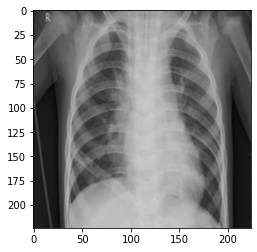

Predicción: PNEUMONIA , Label real: PNEUMONIA


In [54]:
random = np.random.randint(500)
print(random)
prueba = modelo(data_test[random][0].cuda())
label_modelo = torch.argmax(prueba, dim=1).cpu().numpy()

# Mostramos la imagen aleatoria
plt.imshow(data_test[random][0].permute(1,2,0))
plt.show()

# Vemos la clasificación del modelo vs el label real
if label_modelo == [1]:
    label_modelo = 'PNEUMONIA'
else:
    label_modelo = 'NORMAL'
if data_test[random][1] == 1:
    label = 'PNEUMONIA'
else:
    label = 'NORMAL'
    
print('Predicción:', label_modelo, ', Label real:', label)

# P3 Interpretabilidad

## 1.

In [56]:
import torch
from torchvision import transforms

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

seed=77

#Define la transformación de datos pedida
data_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [57]:
dev

device(type='cuda')

## 2.

In [60]:
from PIL import Image

#Carga la imagen de control
control_img = Image.open('llama.jpeg')

In [63]:
#Carga red inception_v3
from torchvision import models
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [64]:
inception.to(device=dev)
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [65]:
#Obtiene la prediccion de inception sobre la img de control
from keras.applications.imagenet_utils import decode_predictions
import numpy as np

trans_img = data_transform(control_img).unsqueeze(0)

with torch.no_grad():
    pred_control = inception(trans_img.to(dev))
    
pred_control = decode_predictions(pred_control.cpu().detach().numpy(), top=1)
pred_control

Using TensorFlow backend.


40960/35363 [==================================] - 0s 0us/step


[[('n02437616', 'llama', 9.439326)]]

## 3.

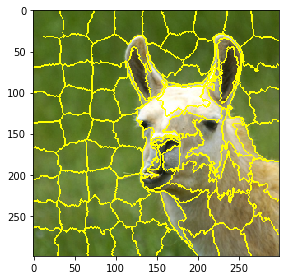

In [66]:
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow

parches = 80
half_transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299)
])

halftrans_img = half_transform(control_img)
segments = slic(halftrans_img, n_segments=parches)
slic_img = mark_boundaries(halftrans_img, segments)
imshow(slic_img)


## 4.

In [67]:
import scipy.stats as stats

n_perturbaciones = 1000
perturbaciones = [stats.bernoulli.rvs(0.5, size=parches) for i in range(n_perturbaciones)]   

In [68]:
perturbaciones[0]

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1])

## 5.

In [150]:
def pert_img_fixed_clusters(clusters, img): 
    def perturbar_img(perturbacion, segments=clusters, img=img):
        img_perturbada = transforms.ToTensor()(img)
        #img_perturbada = mark_boundaries(img, segments)
      
        for k,booleano in enumerate(perturbacion):
            mask = (segments == k+1)
            mask = 1-mask
            if not booleano:
                for dim in range(3):
                    img_perturbada[dim,:,:] *= mask
              
        img_perturbada = transforms.ToPILImage()(img_perturbada)
              
        return img_perturbada
    
    return perturbar_img

perturbar_img = pert_img_fixed_clusters(segments, halftrans_img)
imgs_perturbadas = list(map(perturbar_img, perturbaciones))

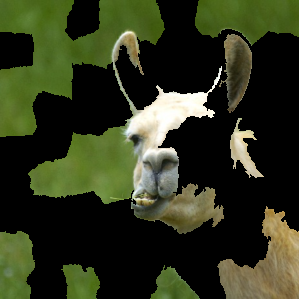

In [151]:
imgs_perturbadas[0].save('perturb_llama.pdf')
imgs_perturbadas[0]

## 6.

In [71]:
from torch.utils.data import DataLoader
import torch

secondhalf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trans_pert_imgs = list(map(secondhalf_transform,imgs_perturbadas))

preds = []

with torch.no_grad():
    inception.eval()
    for i,img in enumerate(trans_pert_imgs):
        img = img.type(torch.float32).unsqueeze(0)
        pred = inception(img.to(dev))
        pred = decode_predictions(pred.cpu().detach().numpy(), top=1)
        preds.append(pred)

y = []
for pred in preds:
    if pred[0][0][1] == pred_control[0][0][1]:
        y.append(1)
    else:
        y.append(0)

## 7.

In [72]:
def dist_cos(x_hat,z_hat):
    return 1 - (np.dot(x_hat,z_hat)/(np.linalg.norm(x_hat)*np.linalg.norm(z_hat)))

def pi_x(z_hat, n, sigma=0.25):
    x_hat = np.ones(n)
    return np.exp(-(dist_cos(x_hat,z_hat)**2)/sigma**2)


pesos_perts = [pi_x(pert,80) for pert in perturbaciones]

## 8.

In [73]:
Dp = (perturbaciones, y)

## 9.

In [74]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(Dp[0],
       Dp[1],
       sample_weight=pesos_perts
      )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

No se divide en train y test, puesto que nos interesa ver que pesos importan al momento de calificar nuestras imágenes. Para ello, es mejor entrenar con todos los datos, así no perdemos información.\\
Notemos que bajo este esquema, dado que el método fit no pérmite agregar sumandos, solo permite agregar un factor con el parámetro sample_weights, no es posible agregar la medida de complejidad.

## 10.

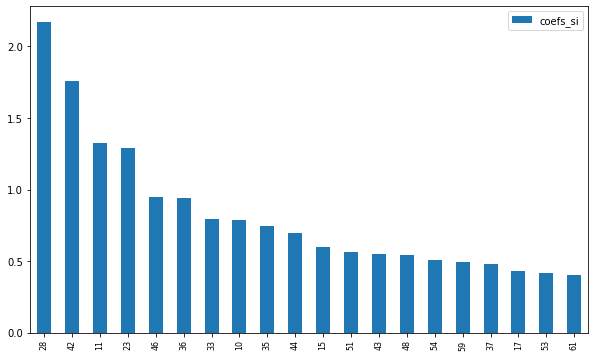

In [75]:
import matplotlib.pyplot as plt
import pandas as pd

coefs = lr.coef_[0]
#Pixeles SI
idx_coefs_si = np.argsort(coefs)[::-1]
coefs_si = np.sort(coefs)[::-1]
df_coefs_si = pd.DataFrame({'coefs_si':coefs_si},index=idx_coefs_si)

#Plots
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.tick_params(axis='x', labelsize=8)
df_coefs_si.nlargest(int(len(coefs_si)/4), 'coefs_si').plot(kind = 'bar', ax=ax)

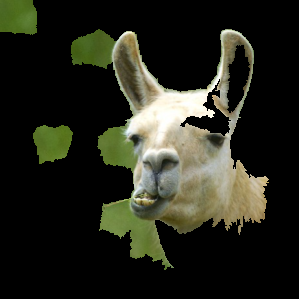

In [81]:
idx_si = idx_coefs_si[:int(len(coefs_si)/4)]
si_pixels = np.zeros(parches)
si_pixels[idx_si] = 1
visual = perturbar_img(si_pixels)
visual.save('pixels_llama.pdf')
visual

## 11.

In [78]:
original_img = half_transform(control_img)
original_img = original_img.convert('L')
original_img = np.array(original_img)

n,m = original_img.shape
X = np.array([(i,j,original_img[i,j]) for i in range(n) for j in range(m)])

### Clustering por KMeans

In [79]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=80, random_state=seed)
clusters_km = km.fit_predict(X)
clusters_km = clusters_km.reshape(299,299)

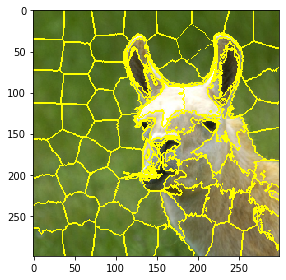

In [80]:
imshow(mark_boundaries(halftrans_img, clusters_km))

### Clutering por Gaussian Mixture

In [82]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=80, random_state=seed)
clusters_gmm = gmm.fit_predict(X)
clusters_gmm = clusters_gmm.reshape(299,299)

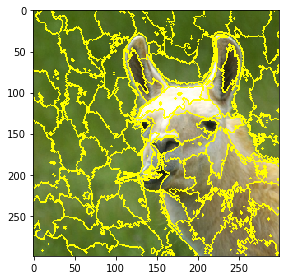

In [83]:
imshow(mark_boundaries(halftrans_img, clusters_gmm))

## 12.

In [85]:
def pre_LIME(clusters, red=inception, img=halftrans_img, n_perturbaciones=n_perturbaciones):
    n_clusters = len(np.unique(clusters))
    perturbaciones = [stats.bernoulli.rvs(0.5, size=n_clusters) for i in range(n_perturbaciones)]

    perturbar_img = pert_img_fixed_clusters(clusters)
    imgs_perturbadas = list(map(perturbar_img, perturbaciones))

    secondhalf_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

    trans_pert_imgs = list(map(secondhalf_transform,imgs_perturbadas))

    preds = []

    with torch.no_grad():
        red.eval()
        for i,img in enumerate(trans_pert_imgs):
            img = img.type(torch.float32).unsqueeze(0)
            pred = red(img.to(dev))
            pred = decode_predictions(pred.cpu().detach().numpy(), top=1)
            preds.append(pred)
    
    y = []
    for pred in preds:
      if pred[0][0][1] == pred_control[0][0][1]:
        y.append(1)
      else:
        y.append(0)

    pesos_perts = [pi_x(pert, n_clusters) for pert in perturbaciones]
    Dp = (perturbaciones, y)

    lr = LogisticRegression()
    lr.fit(Dp[0],
           Dp[1],
           sample_weight=pesos_perts
          )

    coefs = lr.coef_[0]
    #Pixeles SI
    idx_coefs_si = np.argsort(coefs)[::-1]
    coefs_si = np.sort(coefs)[::-1]

    idx_si = idx_coefs_si[:int(len(coefs_si)/4)]
    si_pixels = np.zeros(n_clusters)
    si_pixels[idx_si] = 1
    visual = perturbar_img(si_pixels)

    return visual

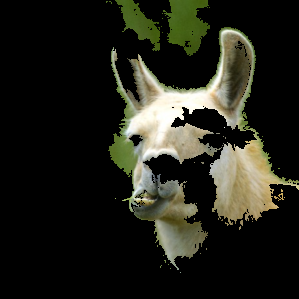

In [86]:
img_gmm = pre_LIME(clusters_gmm)
img_gmm.save('gmm_llama.pdf')
img_gmm

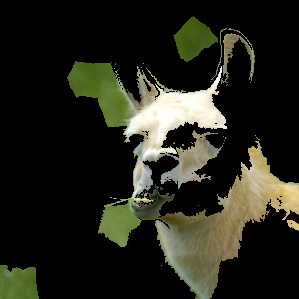

In [87]:
img_km = pre_LIME(clusters_km)
img_km.save('km_llama.pdf')
img_km

In [156]:
def LIME(img=control_img, n_clusters=80, red=inception, n_perturbaciones=n_perturbaciones, seed=seed):

    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
  
    data_transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    trans_img = data_transform(control_img).unsqueeze(0)

    with torch.no_grad():
        red.eval()
        pred_control = red(trans_img.to(dev))
    pred_control = torch.argmax(pred_control, dim=1).cpu().numpy()
    #pred_control = decode_predictions(pred_control.cpu().detach().numpy(), top=1)

    half_transform = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.CenterCrop(224),
      ])

    halftrans_img = half_transform(img)
  
    gray_img = halftrans_img.convert('L')
    gray_img = np.array(gray_img)

    n,m = gray_img.shape
    X = np.array([(i,j,gray_img[i,j]) for i in range(n) for j in range(m)])
  
    gmm = GaussianMixture(n_components=n_clusters, random_state=seed)
    clusters = gmm.fit_predict(X)
    clusters = clusters.reshape(224,224)

    perturbaciones = [stats.bernoulli.rvs(0.5, size=n_clusters) for i in range(n_perturbaciones)]

    perturbar_img = pert_img_fixed_clusters(clusters, halftrans_img)
    imgs_perturbadas = list(map(perturbar_img, perturbaciones))

    secondhalf_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

    trans_pert_imgs = list(map(secondhalf_transform,imgs_perturbadas))

    preds = []

    with torch.no_grad():
        red.eval()
        for i,img in enumerate(trans_pert_imgs):
            img = img.type(torch.float32).unsqueeze(0)
            pred = red(img.to(dev))
            #pred = decode_predictions(pred.cpu().detach().numpy(), top=1)
            pred = torch.argmax(pred, dim=1).cpu().numpy()
            preds.append(pred)

    y = []
    for pred in preds:
        if pred == pred_control:
            y.append(1)
        else:
            y.append(0)

    pesos_perts = [pi_x(pert,n_clusters) for pert in perturbaciones]
    Dp = (perturbaciones, y)

    lr = LogisticRegression()
    lr.fit(Dp[0],
       Dp[1],
       sample_weight=pesos_perts
      )
  
    coefs = lr.coef_[0]
    #Pixeles SI
    idx_coefs_si = np.argsort(coefs)[::-1]
    coefs_si = np.sort(coefs)[::-1]

    idx_si = idx_coefs_si[:int(len(coefs_si)/4)]
    si_pixels = np.zeros(n_clusters)
    si_pixels[idx_si] = 1
    visual = perturbar_img(si_pixels)

    return visual

In [157]:
pulmon = loader('chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg')

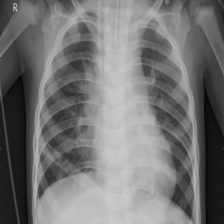

In [158]:
toimage = transforms.ToPILImage()
test_image = toimage(data_test[478][0])
test_image

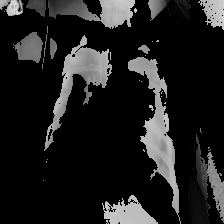

In [159]:
img_test = LIME(pulmon, red = modelo)
img_test.save('test.pdf')
img_test